Esse arquivo se destina a analisar exclusivamente os coeficientes alpha, beta e tetha para a função de custo
      (y−y_ref)^2, peso=1 + α(ẏ−ẏ_ref)^2 β(β−β_ref)^2 + δ(β̇−β̇_ref)^2
A analise é de forma separada, ou seja quando alpha = x, beta e delta = 0, assim analisaremos a influencia de cada parametro no modelo

In [2]:
import pandas as pd
import glob
import time
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import animation
import matplotlib.colors as mcolors
import statistics
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation
from PIL import Image
import random

def read_generic(name, n_states):
    """
    Leitura genérica de CSV em dois formatos:
    
    1) CSV de trials (tab-delimitado, coluna 0 = "s0,...,sN,g0,...,gN", col1=Time, col2=Trial)
    2) CSV de média (_avg.csv gerado por pandas): colunas separadas Time, State0…StateN-1,
       opcionalmente Goal0…GoalN-1, Trial
    
    Retorna dict com
      'states': (n_states, N),  'goals': (n_states, N),
      't': (N,),  'trial': (N,)
    """
    # — caso _avg.csv —
    if name.endswith('_avg.csv'):
        df = pd.read_csv(name)
        state_cols = [f"State{i}" for i in range(n_states)]
        states = df[state_cols].values.T
        
        goal_cols = [f"Goal{i}" for i in range(n_states)]
        if all(col in df.columns for col in goal_cols):
            goals = df[goal_cols].values.T
        else:
            # sem coluna de meta → posição = 1.0, demais estados = 0.0
            goals = np.zeros_like(states)
            goals[0, :] = 1.0
        
        t     = df["Time"].values
        trial = df["Trial"].values if "Trial" in df.columns else np.zeros_like(t, dtype=int)
        
        return {"states": states, "goals": goals, "t": t, "trial": trial}

    # — caso CSV original de trials —
    states, goals, t_list, trials = [], [], [], []
    with open(name, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        next(reader)
        for row in reader:
            if not row or len(row) < 3:
                continue
            parts = re.split(r"[,\s\t]+", row[0].strip())
            vals  = [float(x) for x in parts if x]
            s = np.array(vals[0:   n_states])
            g = np.array(vals[n_states:2*n_states])
            states.append(s)
            goals.append(g)
            t_list.append(float(row[1]))
            trials.append(int(float(row[2])))

    if not states:
        raise ValueError(f"Não consegui ler dados em '{name}'")

    return {
        "states": np.vstack(states).T,
        "goals" : np.vstack(goals).T,
        "t"     : np.array(t_list),
        "trial" : np.array(trials, dtype=int)
    }

def create_generic_series(Title, Subtitles, all_data, state_labels, t_lim=None):
    """
    Gráfico genérico de séries temporais para N estados.
    Title        : título geral
    Subtitles    : lista de legendas (uma por experimento)
    all_data     : lista de dicts retornados por read_generic
    state_labels : nomes das variáveis de estado
    t_lim        : limite de tempo em xlim
    """
    n = len(state_labels)
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(10, 5 * n))

    # 1) plota o degrau (goal) primeiro
    for i, name in enumerate(state_labels):
        axes[i].plot(
            all_data[0]['t'],
            all_data[0]['goals'][i],
            '--', label=f"{name}_goal"
        )
    # 2) plota as séries de dados
    for data, label in zip(all_data, Subtitles):
        for i, name in enumerate(state_labels):
            axes[i].plot(data['t'], data['states'][i], label=label)

    for i, name in enumerate(state_labels):
        axes[i].set_ylabel(name)
        if t_lim is not None:
            axes[i].set_xlim(0, t_lim)

    axes[-1].set_xlabel("Time [s]")
    fig.suptitle(Title)
    axes[0].legend(loc='upper right')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# — Wrappers para retrocompatibilidade —

def read_one(name):
    # Leitura 1D (posição e velocidade)
    data = read_generic(name, n_states=4)
    return {
        'states': data['states'][:2],
        'goals' : data['goals'][:2],
        't'     : data['t'],
        'trial' : data['trial']
    }

def Create_1D_Graphic(Title, Subtitles, Data):
    """
    Dois painéis: posição (topo) e velocidade (baixo). 
    Alvos em t=1+tr_target, y=1*(1+Mp_target/100), t=1+Ts_target no 
    painel de posição, e legenda à direita.
    """

    # — parâmetros de controle —
    tr_target = 1.5   # rise time desejado (s após t=1)
    Mp_target = 5.0   # overshoot desejado (%)
    Ts_target = 2.0   # settling time desejado (s após t=1)
    # ——————————————

    fig, (ax_pos, ax_vel) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(Title, fontsize=14)

    t = Data[0]['t']
    step = np.where(t >= 1.0, 1.0, 0.0)

    # desenha step
    ax_pos.plot(t, step, 'k--', label="Goal (step)")
    ax_vel.plot(t, np.zeros_like(t), 'k--', label="_nolegend_")

    # desenha alvos fixos
    ax_pos.axvline(1 + tr_target, color='r', linestyle='--', label=f"Tr target={tr_target}s")
    ax_pos.axhline(1*(1+Mp_target/100), color='m', linestyle=':', label=f"Mp target={Mp_target}%")
    ax_pos.axvline(1 + Ts_target, color='c', linestyle='-.', label=f"Ts target={Ts_target}s")

    # plota cada curva
    for i, (label, D) in enumerate(zip(Subtitles, Data)):
        c = f"C{i}"
        ax_pos.plot(D['t'], D['states'][0], color=c, label=label)
        ax_vel.plot(D['t'], D['states'][1], color=c)

    # —— aqui as linhas que garantem o box até 5s ——
    ax_pos.set_xlim(0, 5)
    ax_vel.set_xlim(0, 5)

    ax_pos.set_ylabel("Position [m]")
    ax_vel.set_ylabel("Velocity [m/s]")
    ax_vel.set_xlabel("Time [s]")

    # legenda única no topo, à direita
    ax_pos.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    plt.show()

def Create_1D_Graphic2(Title, Subtitles, Data, t):
    create_generic_series(Title, Subtitles, Data, ["x", "x_dot"], t)

def read_one_2D(name):
    return read_generic(name, n_states=4)

def Create_2D_Graphic(Title, Data, t_lim=None):
    """
    Mantém layout espacial + de séries em X/Y, mas usando data dict.
    """
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 2, 1])

    X  = plt.subplot(gs[0, 0]); X.set_title("Position X")
    XY = plt.subplot(gs[:, 1]);  XY.set_title("Position 2D")
    Y  = plt.subplot(gs[0, 2]); Y.set_title("Position Y")
    XD = plt.subplot(gs[1, 0]); XD.set_title("Velocity X")
    YD = plt.subplot(gs[1, 2]); YD.set_title("Velocity Y")

    goal = Data[0]['goals']
    tvec = Data[0]['t']
    X.plot(tvec, goal[0], '--', label='x_goal')
    Y.plot(tvec, goal[2], '--', label='y_goal')
    XY.plot(goal[0], goal[2], 'o', label='goal')
    XD.plot(tvec, goal[1], '--', label='x_dot_goal')
    YD.plot(tvec, goal[3], '--', label='y_dot_goal')

    for idx, D in enumerate(Data):
        lbl = f"Run {idx}"
        X.plot(D['t'], D['states'][0], label=lbl)
        Y.plot(D['t'], D['states'][2], label=lbl)
        XY.plot(D['states'][0], D['states'][2], label=lbl)
        XD.plot(D['t'], D['states'][1], label=lbl)
        YD.plot(D['t'], D['states'][3], label=lbl)

    for ax in [X, XD, Y, YD]:
        if t_lim is not None:
            ax.set_xlim(0, t_lim)
        ax.set_xlabel("[s]")
    X.set_ylabel("[m]")
    XD.set_ylabel("[m/s]")
    Y.set_ylabel("[m]")
    YD.set_ylabel("[m/s]")

    XY.set_xlabel("X [m]")
    XY.set_ylabel("Y [m]")
    XY.set_xlim(-4, 4)
    XY.set_ylim(-4, 4)

    X.legend(loc='upper right')
    fig.suptitle(Title, fontsize=20)
    plt.tight_layout()
    plt.show()


# Analise do Alpha #

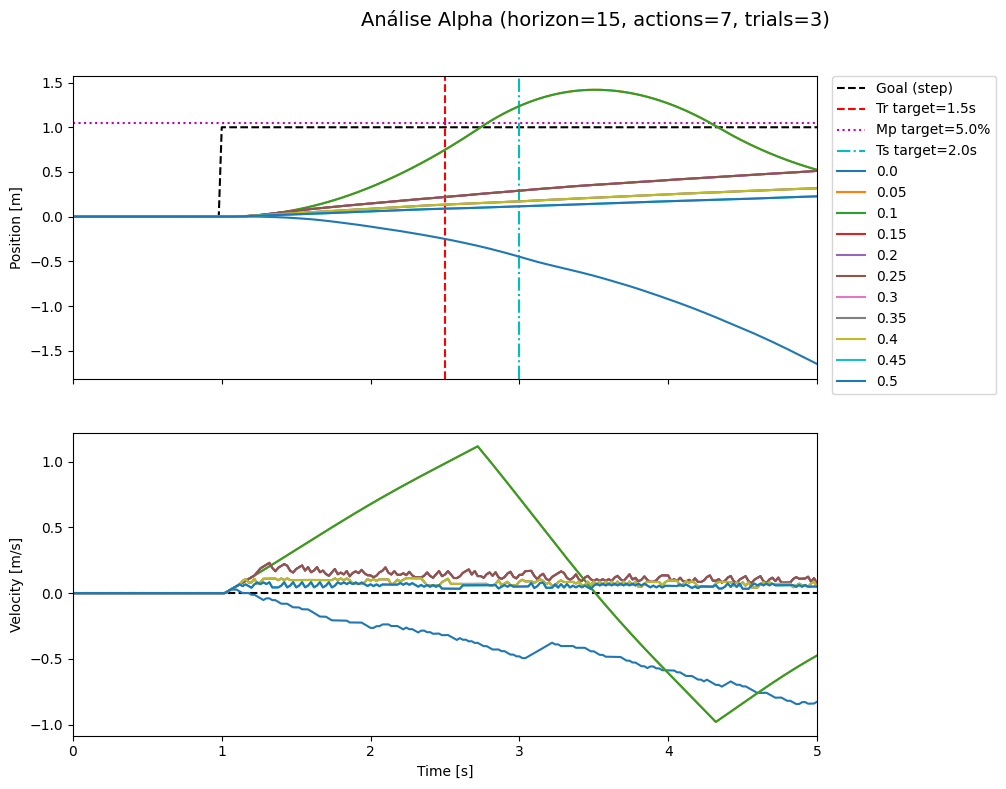

In [45]:
Data = []
L = []

# Sweep α: 0.00 → 0.50 em passo de 0.05 → 11 pontos
n_alpha = int(0.5 / 0.05) + 1  # = 11
for i in range(n_alpha):
    idx = i + 1
    alpha_val = round(i * 0.05, 2)
    # lê o CSV renomeado: Alfa1.csv … Alfa11.csv
    Data.append(read_one(f'Data/Alpha/1/Alpha{idx}Data0.csv'))
    L.append(alpha_val)

Create_1D_Graphic("Análise Alpha (horizon=15, actions=7, trials=3)",L,Data)


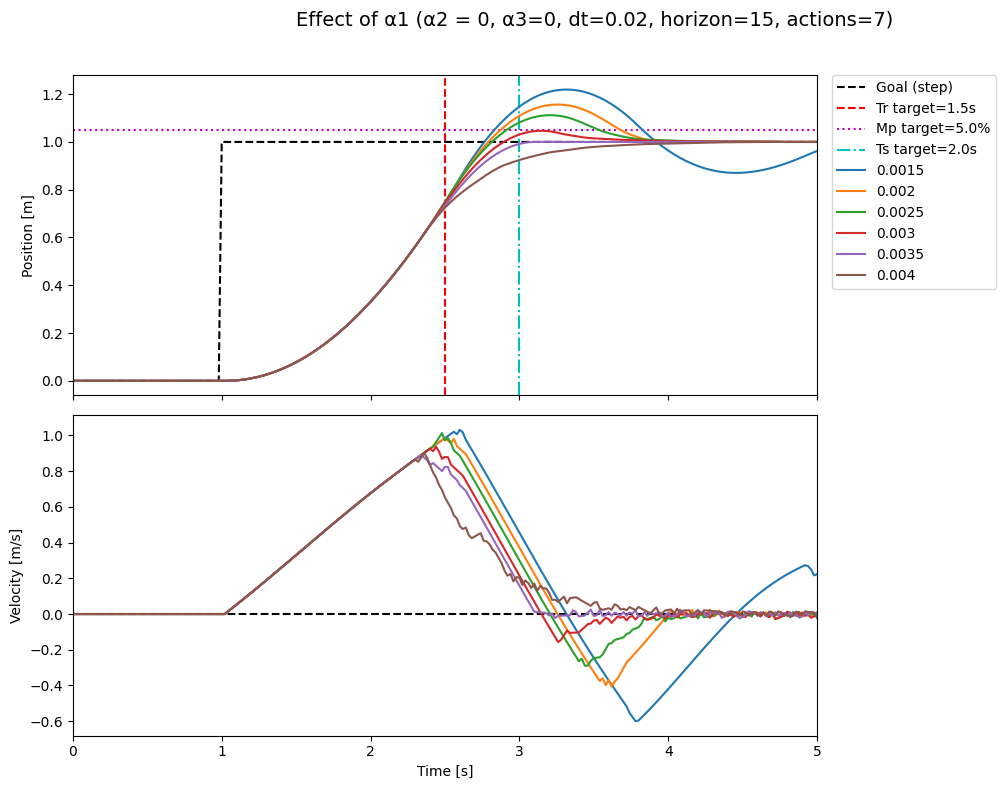

In [15]:
Data = []
L = []

# 1) lê o primeiro CSV para extrair 't' e 'goals' como referência de degrau
#sim0 = read_one('Data/Alpha/2/Alfa1.csv')
#goal_dict = {
#    't': sim0['t'],
#    'states': sim0['goals'],   # para que o degrau apareça também como "state"
#    'goals': sim0['goals']
#}
#Data.append(goal_dict)
#L.append('Goal')

# 2) lê as simulações de Alfa1…Alfa7 (α de 0.001 a 0.004 em passo de 0.0005)
n_alpha = int((0.004 - 0.001) / 0.0005) + 1  # = 7
for i in range(n_alpha):
    idx = i +1
    alpha_val = round(0.001 + i * 0.0005, 4)
    sim = read_one(f'Data/Alpha/2/Alfa{idx}.csv')
    Data.append(sim)
    L.append(alpha_val)

# 3) gera o gráfico, usando o primeiro item como degrau de meta
Create_1D_Graphic(
    "Effect of α1 (α2 = 0, α3=0, dt=0.02, horizon=15, actions=7)",
    L[1:],
    Data[1:]
)

# Analise do Beta #

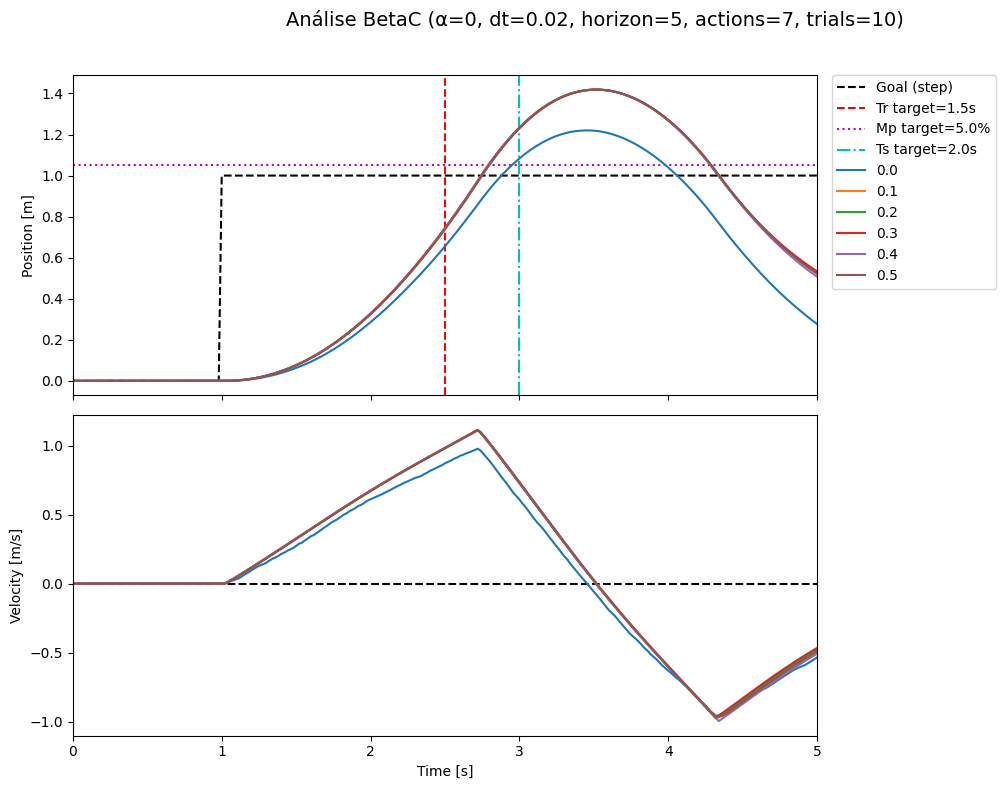

In [47]:
Data = []
betas = []

# Varredura de β: 0.0 ≤ β ≤ 0.9 em passos de 0.1 → 10 pontos
start   = 0.0
end     = 0.5
step    = 0.1
n_beta  = int((end - start) / step) + 1  # = 10

for i in range(n_beta):
    idx      = i + 1
    beta_val = round(start + i * step, 1)
    # lê sempre o primeiro trial (Data1) de cada simulação
    path = f'Data/BetaC/1/Beta{idx}Data_avg.csv'
    Data.append(read_one(path))
    betas.append(beta_val)

Create_1D_Graphic("Análise BetaC (α=0, dt=0.02, horizon=5, actions=7, trials=10)", betas, Data)


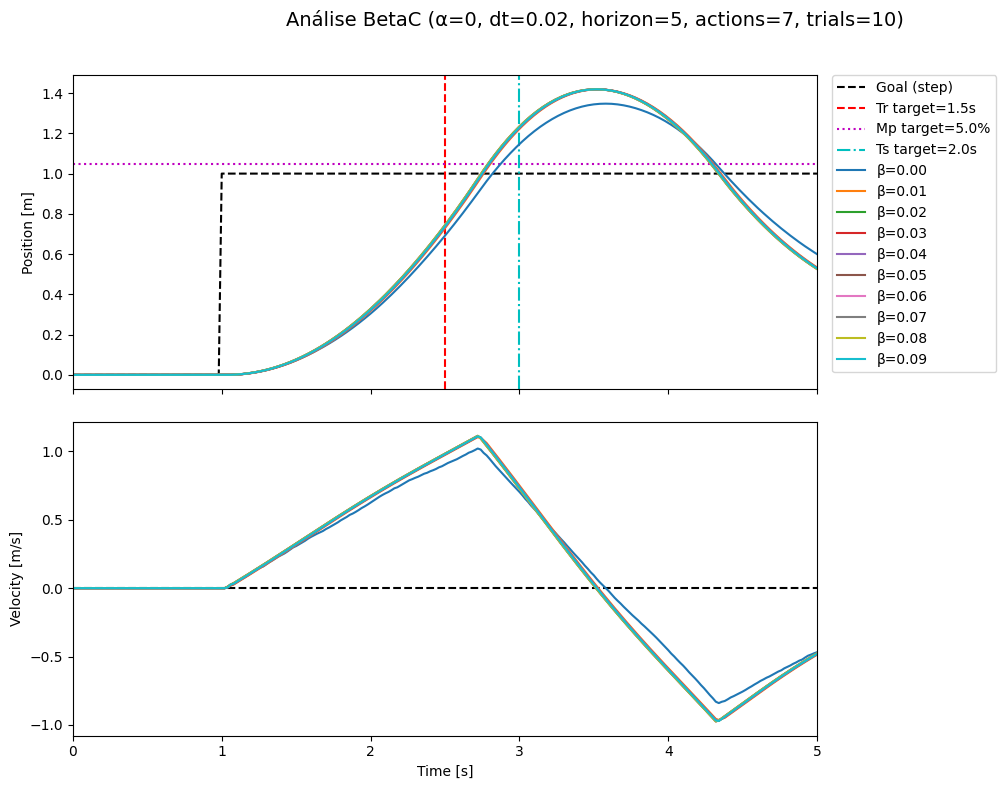

In [ ]:
Data      = []
betas     = []
subtitles = []

# Varredura de β: 0.00 ≤ β ≤ 0.09 em passos de 0.01 → 10 pontos
start   = 0.00
end     = 0.09
step    = 0.01
n_beta  = int((end - start) / step) + 1  # = 10

for i in range(n_beta):
    idx      = i + 1
    beta_val = round(start + i * step, 2)
    path     = f'Data/BetaC/2/Beta{idx}Data_avg.csv'  # ou '...Data_avg.csv' se for médio

    Data.append( read_one(path) )
    betas.append(beta_val)
    subtitles.append(f"β={beta_val:.2f}")

# agora passo subtitles em vez de betas
Create_1D_Graphic(
    "Effect of β (α=0, dt=0.02, horizon=5, actions=7, trials=10)",
    subtitles,
    Data
)



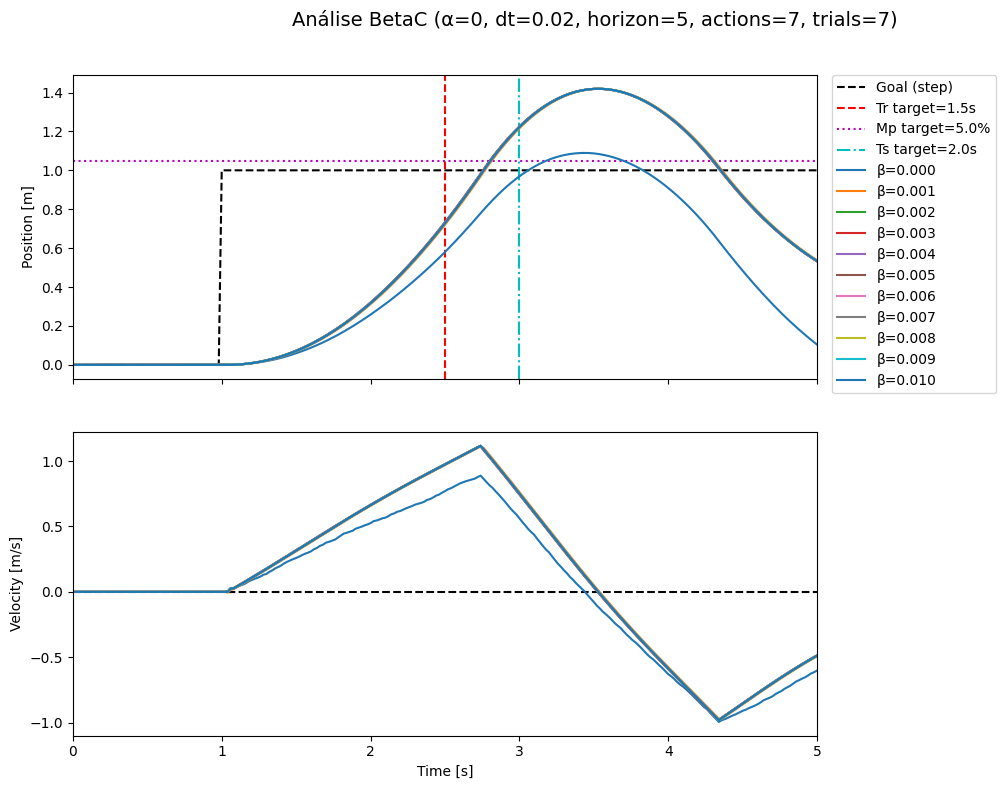

In [73]:
Data      = []
betas     = []
subtitles = []

# Varredura de β: 0.00 ≤ β ≤ 0.01 em passos de 0.001 → 11 pontos
start   = 0.00
end     = 0.01
step    = 0.001
n_beta  = int((end - start) / step) + 1  # = 11

for i in range(n_beta):
    idx      = i + 1
    beta_val = round(start + i * step, 3)
    path     = f'Data/BetaC/3/Beta{idx}Data_avg.csv'  # ou '...Data_avg.csv' se for médio

    Data.append( read_one(path) )
    betas.append(beta_val)
    subtitles.append(f"β={beta_val:.3f}")

# agora passo subtitles em vez de betas
Create_1D_Graphic(
    "Análise BetaC (α=0, dt=0.02, horizon=5, actions=7, trials=7)",
    subtitles,
    Data
)


Para esse valor de beta prox de 0.0001, conseguimos aumentar a rapidez do sistema em termo de Tr = tempo de subida

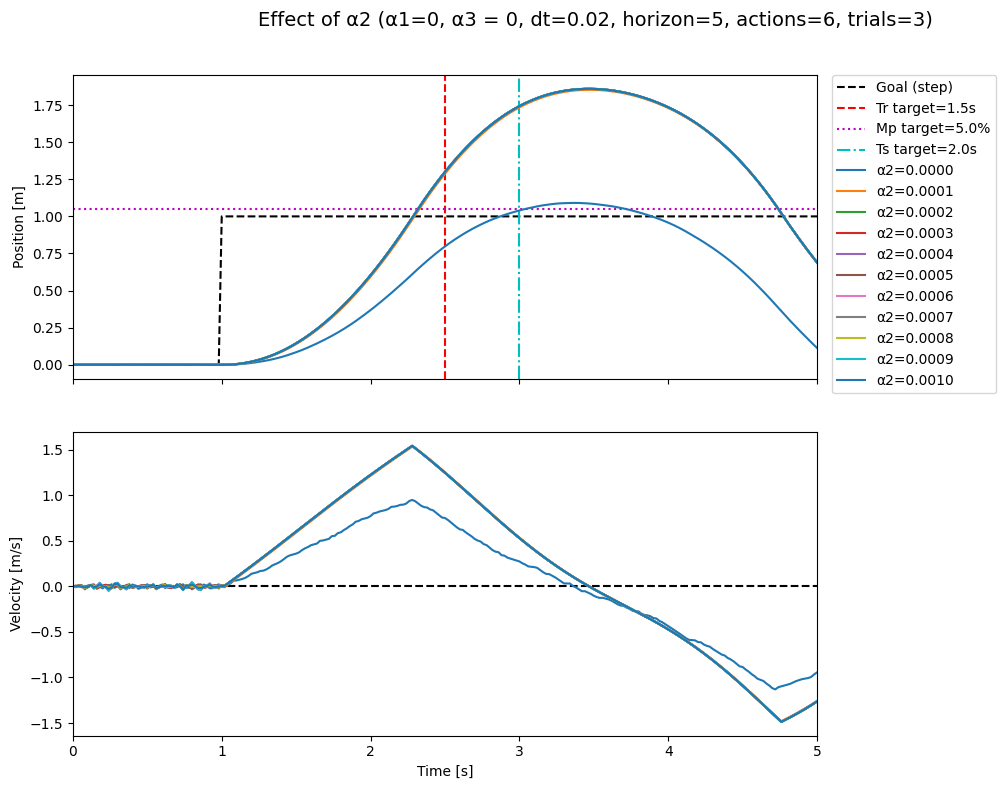

In [13]:
Data      = []
betas     = []
subtitles = []

# Varredura de β: 0.000 ≤ β ≤ 0.001 em passos de 0.001 → 11 pontos
start   = 0.000
end     = 0.001
step    = 0.0001
n_beta  = int((end - start) / step) + 1  # = 11

for i in range(n_beta):
    idx      = i + 1
    beta_val = round(start + i * step, 4)
    path     = f'Data/BetaC/4/Beta{idx}Data_avg.csv'  # ou '...Data_avg.csv' se for médio

    Data.append( read_one(path) )
    betas.append(beta_val)
    subtitles.append(f"α2={beta_val:.4f}")

# agora passo subtitles em vez de betas
Create_1D_Graphic(
    "Effect of α2 (α1=0, α3 = 0, dt=0.02, horizon=5, actions=6, trials=3)",
    subtitles,
    Data
)


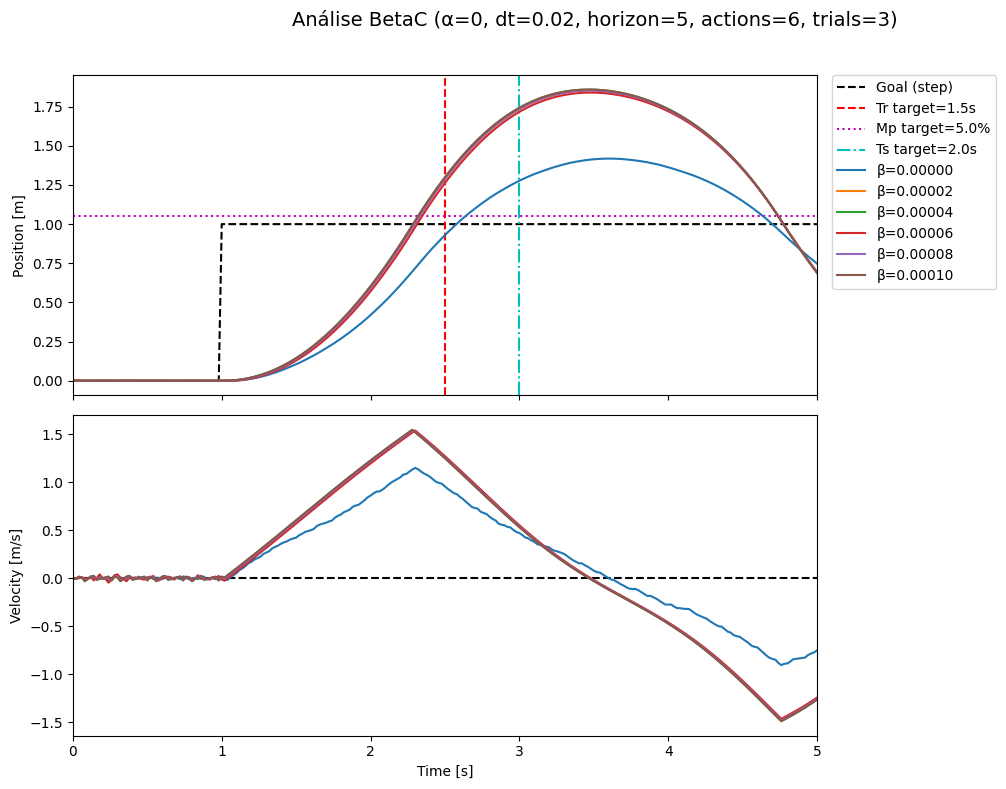

In [78]:
Data      = []
betas     = []
subtitles = []

# Varredura de β: 0.0000 ≤ β ≤ 0.0001 em passos de 0.00002→ 6 pontos
start   = 0.0000
end     = 0.0001
step    = 0.00002
n_beta  = int((end - start) / step) + 1  # = 6

for i in range(n_beta):
    idx      = i + 1
    beta_val = round(start + i * step, 5)
    path     = f'Data/BetaC/5/Beta{idx}Data_avg.csv'  # ou '...Data_avg.csv' se for médio

    Data.append( read_one(path) )
    betas.append(beta_val)
    subtitles.append(f"β={beta_val:.5f}")

# agora passo subtitles em vez de betas
Create_1D_Graphic(
    "Análise BetaC (α=0, dt=0.02, horizon=5, actions=6, trials=3)",
    subtitles,
    Data
)


# Analise Delta #

Para esses valores de Delta, é possivel observar que entre 0.00 e o.03 eu tenho respostas cada vez mais rápidas mas aumentando o overshoot, porém os demais aumentam o overshoot sem melhorar o tempo de resposta.

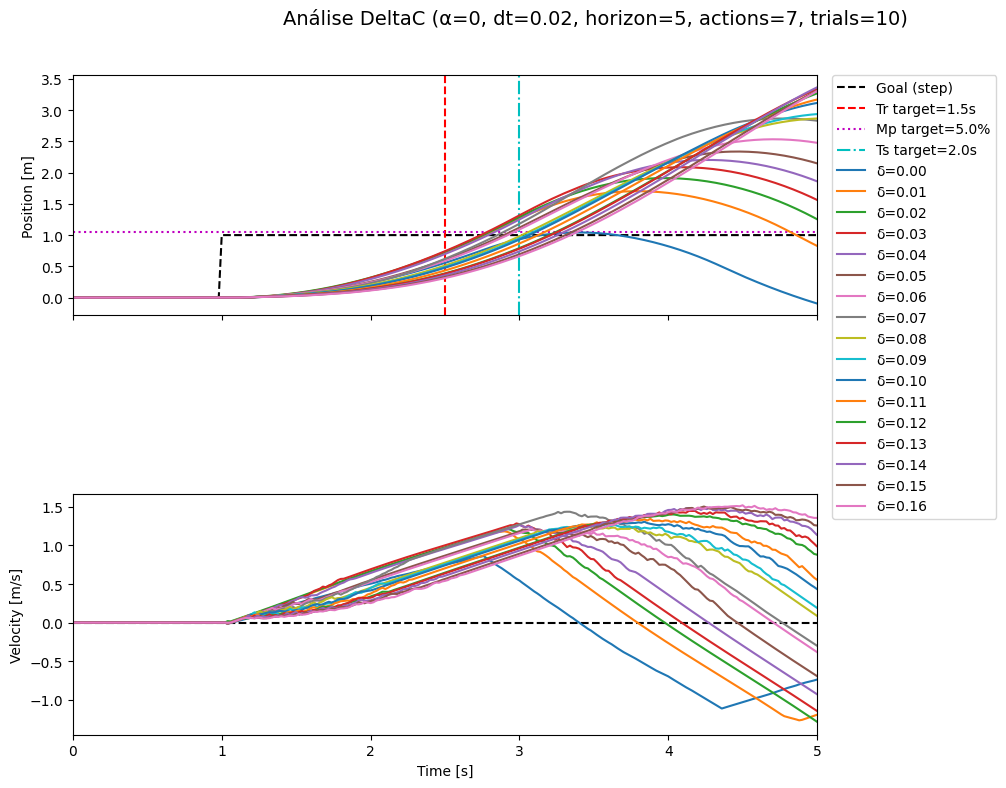

In [57]:
Data      = []
deltas    = []
subtitles = []

# Varredura de δ: 0.00 ≤ δ ≤ 0.16 em passos de 0.01 → 17 pontos
start    = 0.00
end      = 0.16
step     = 0.01
n_delta  = int((end - start) / step) + 1  # = 17

for i in range(n_delta):
    idx       = i + 1
    delta_val = round(start + i * step, 2)
    # ajuste o caminho abaixo conforme sua estrutura de pastas
    path      = f'Data/DeltaC/1/Delta{idx}Data_avg.csv'

    Data.append( read_one(path) )
    deltas.append(delta_val)
    subtitles.append(f"δ={delta_val:.2f}")

# agora passo subtitles em vez de deltas (ou use deltas, se preferir)
Create_1D_Graphic(
    "Análise DeltaC (α=0, dt=0.02, horizon=5, actions=7, trials=10)",
    subtitles,
    Data
)


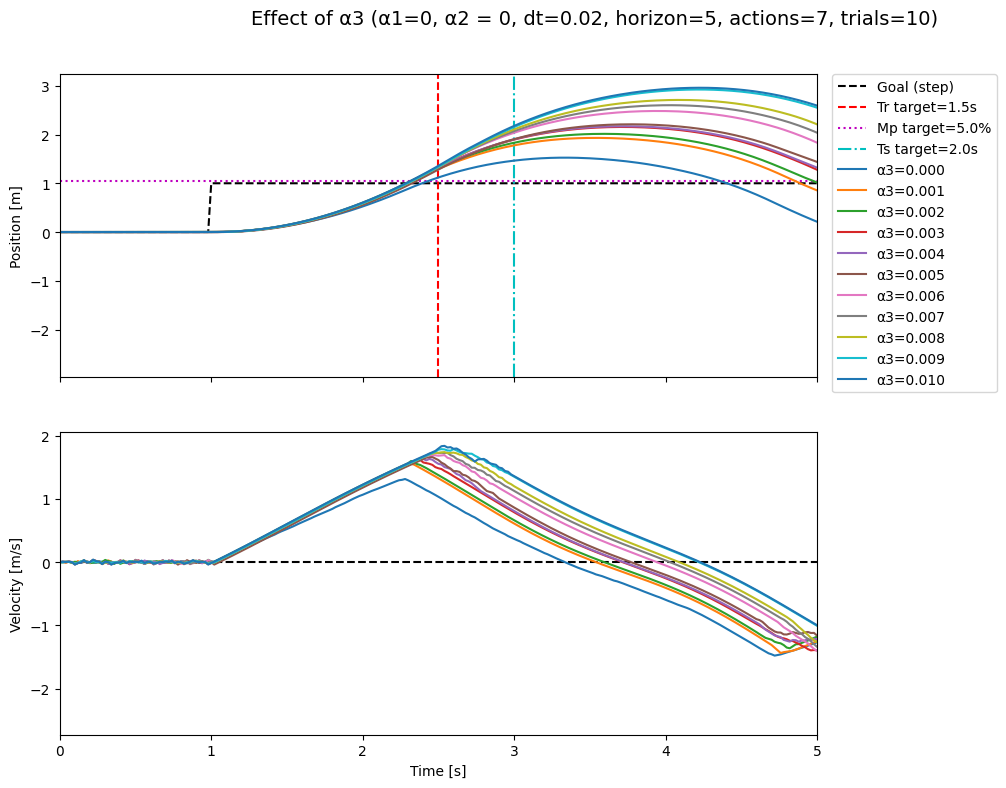

In [16]:
Data      = []
deltas    = []
subtitles = []

# Varredura de δ: 0.00 ≤ δ ≤ 0.01em passos de 0.001 → 11 pontos
start    = 0.000
end      = 0.01
step     = 0.001
n_delta  = int((end - start) / step) + 1  # = 11

for i in range(n_delta):
    idx       = i + 1
    delta_val = round(start + i * step, 3)
    # ajuste o caminho abaixo conforme sua estrutura de pastas
    path      = f'Data/DeltaC/3/Delta{idx}Data_avg.csv'

    Data.append( read_one(path) )
    deltas.append(delta_val)
    subtitles.append(f"α3={delta_val:.3f}")

# agora passo subtitles em vez de deltas (ou use deltas, se preferir)
Create_1D_Graphic(
    "Effect of α3 (α1=0, α2 = 0, dt=0.02, horizon=5, actions=7, trials=10)",
    subtitles,
    Data
)

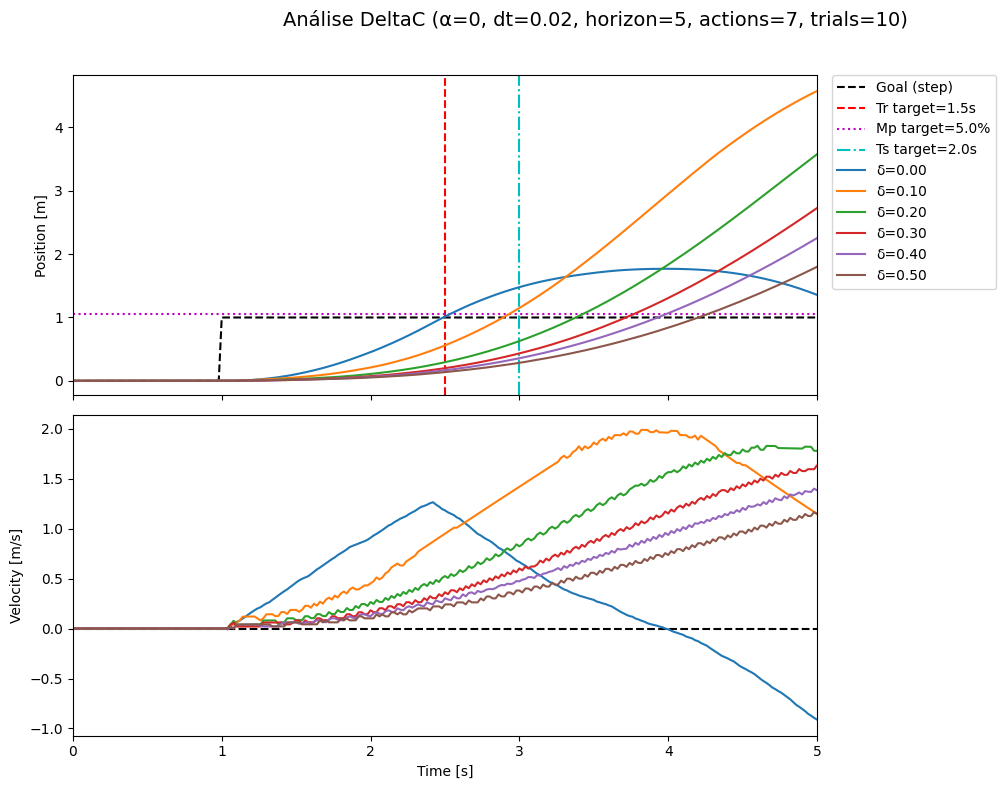

In [53]:
Data      = []
deltas    = []
subtitles = []

# Varredura de δ: 0.00 ≤ δ ≤ 1.00 em passos de 0.01 → 11 pontos
start    = 0.00
end      = 0.5
step     = 0.1
n_delta  = int((end - start) / step) + 1  # = 11

for i in range(n_delta):
    idx       = i + 1
    delta_val = round(start + i * step, 2)
    # ajuste o caminho abaixo conforme sua estrutura de pastas
    path      = f'Data/DeltaC/2/Delta{idx}Data_avg.csv'

    Data.append( read_one(path) )
    deltas.append(delta_val)
    subtitles.append(f"δ={delta_val:.2f}")

# agora passo subtitles em vez de deltas (ou use deltas, se preferir)
Create_1D_Graphic(
    "Análise DeltaC (α=0, dt=0.02, horizon=5, actions=7, trials=10)",
    subtitles,
    Data
)

# Tentativa pra ver o que acontece com um peso(δ) negativo no custo da velocidade angular
# Conclusão: Não deu certo 

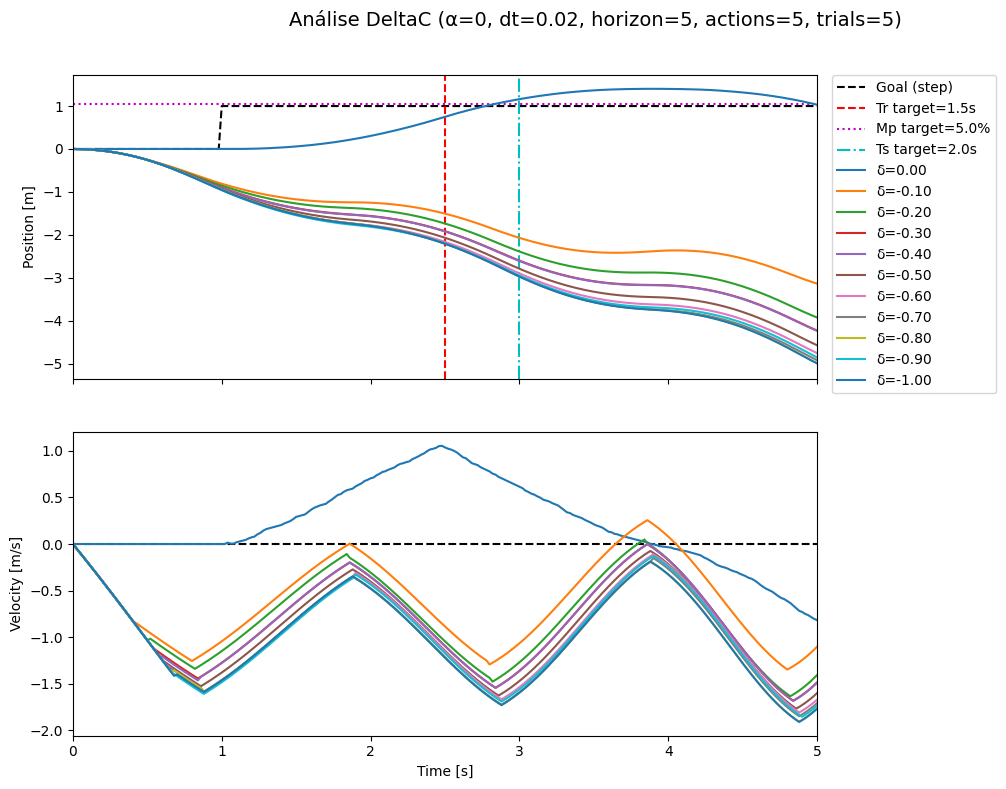

In [43]:
Data      = []
deltas    = []
subtitles = []

# Varredura de δ: de 0.0 até –1.0 em decrementos de 0.1 → 11 pontos
start    =  0.0
end      = -1.0
step     = -0.1
n_delta  = int((start - end) / abs(step)) + 1  # = 11

for i in range(n_delta):
    # índice de arquivo (Delta1, Delta2, …, Delta11)
    idx       = i + 1
    # valor de delta (0.00, –0.10, …, –1.00)
    delta_val = round(start + i * step, 2)

    # caminho para o CSV correspondente
    path      = f'Data/DeltaC/5/Delta{idx}Data_avg.csv'

    Data.append( read_one(path) )
    deltas.append(delta_val)
    subtitles.append(f"δ={delta_val:.2f}")

# Agora plota usando as legendas “δ=0.00”, “δ=-0.10”, …
Create_1D_Graphic(
    "Análise DeltaC (α=0, dt=0.02, horizon=5, actions=5, trials=5)",
    subtitles,
    Data
)
